# Neural Networks and Learning Machines
## ANN 1 - Training, validation, and testing
This exercise is split into three different parts. First, you will test some simple machine learning models that aren't neural networks. Secondly, you will implement and train a 2 layer neural network using a high level library, [pytorch](https://pytorch.org/). Finally, you will create the neural network, the forward pass and the backward pass from scratch using numpy. The data which will be used is a subset of the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset which contains handwritten numbers from 0-9. Examples can be seen in the image below.

![MNIST digits](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)

## Literature
Before starting with the implementation you should familiarize yourself with relevant sections from the [course book](https://www.deeplearningbook.org/). This will help you understand the theory behind neural networks and what mathematical formulas are important for the task. The lectures has touched on most of these concepts too. Below will be a list of recommended sections from the book. If you feel you are already familiarize with the contents of the section, feel free to skip it.

* Chapter 5 - Machine learning basics
    - Section 5.1 - Explains the basics of what we mean by learning and what supervised learning is (including linear regression).
    - Section 5.2 - Talks about generalization, the generalization gap and under/overfitting.
    - Section 5.3 - Validation and validation set.
* Chapter 6 - Deep feedforward networks
    - Section 6.0 - Discusses what do we mean by feedfoward networks and terminology such as input layer, output layer and hidden layer.
    - Section 6.2 - Discusses what gradient based learning is and what cost functions are.
    - Section 6.5 - Explains back propagation. Important here are the formulas 6.49 - 6.52.
* Chapter 8 - Optimization for Training Deep Models
    - Section 8.1.3 - Presents differences between batch (deterministic) and mini-batch (stochastic) algorithms.
    
## Examination

### Part 1

* Try 4 machine learning models that are not Neural Networks using scikit-learn: decision tree, linear regression, logistic regression, and Support-Vector Machine (SVM)
* Write a short description of the main difference between linear and logistic regression in the provided cell.

### Part 2
* Implementation of a 2 layer NN (very similar to ex0)
* Training of this 2 layer NN (once again, very similar to ex0)
* Validation of the network during training (requires splitting the training set)
    - Save the model which performs the best on the validation data
* Graph the training loss vs validation loss
* At least 85% accuracy on the test data (remember to load the best performing model before performing the accuracy test)

### Part 3
* Implementation of a 2 layer NN using numpy
* Training and validation of the 2 layer NN
    - Once again, save the best performing model (can be done in memory)
* Graph the training vs validation loss
* At least 50% accuracy on the validation data (can be hard to get high accuracy)

# MNIST dataset preparation
We will start by importing the packages we'll be using as well as downloading and preparing the data such that it is usable for our purposes.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision import datasets, transforms

from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

import random
import matplotlib.pyplot as plt
import numpy
import copy

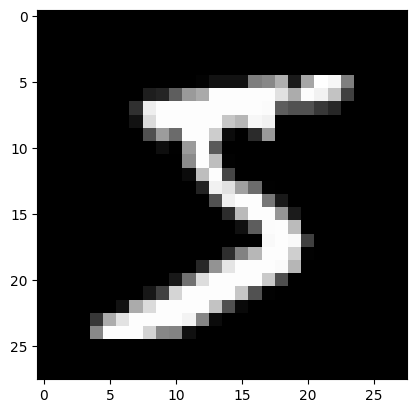

In [80]:
# Define the mini-batch size
batch_size = 1000

# Download the dataset and create the dataloaders
mnist_train = datasets.MNIST("./", train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=False)
## IN PART 2 YOU MAY WANT TO ADD A WAY TO SPLIT THE DATASET HERE##



mnist_test = datasets.MNIST("./", train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

to_onehot = nn.Embedding(10, 10)
to_onehot.weight.data = torch.eye(10)

def plot_digit(data):
    data = data.view(28, 28)
    plt.imshow(data, cmap="gray")
    plt.show()

images, labels = next(iter(train_loader))
plot_digit(images[0])

# Part 1

## Test some non-neural network machine learning models

Neural Networks are just a small part of the large field of machine learning. Many machine learning models exist that does not fall under the umbrella of neural networks and it's good to be familiar with some of them.
In this part of the exercise you will test decision tree, linear regression, logistic regression, and Support-Vector Machine (SVM) models using their implementations from the scikit-learn package.

To start with let's have quick walk-through of the methods we'll be using:

**Decision trees** work by inserting a data point into the root of the tree and then by comparing different features of the data point it is sent to the next step in the tree until it reaches a leaf node which contains the final prediction for the data point. There are many different ways to create a tree to fit some training set but training procedures often follow a divide-and-conquer strategy:
* Find an attribute that splits the different classes or labels of the training data as neatly as possible and create a node that splits using that attribute.
* Repeat the procedure to create the subnodes using the training data that subnode would encounter.
* This is repeated for each until either a performance requirement or a certain depth is reached at which point each leaf node is assigned as a predictor for the highest liklihood label to reach that node.

An example of a short decision tree can be found in the image below.
![Decision Tree](https://miro.medium.com/max/720/1*YTg8AE3nAsbfn-elHuJNIA.jpeg)

**Linear regression, logistic regression, and SVM** are all versions of linear models. Linear models work by, for training data in some hyper-space (a space with N dimensions) learning a hyperplane (a plane with N-1 dimensions) that fits the data best. In the case of binary classification the goal is to have as many samples of each class on separate sides of the plane. The calculation of a linear model can be described by the vector equation below, where *x* is the data point and **w** and b are learned parameters, and f() is an activation function.

\begin{equation*}
y = f(\mathbf{w}\mathit{x} + b)
\end{equation*}

As you can see this is identical to the equation of an artificial neuron, and when extended to handle multiple outputs (by using  matrices for **w** and b instead of vectors) become equivalent to a single-layer ANN.
However, even though prediction, in the simplest case, is equivalent to a single-layer neural network there are many different linear models that vary in different ways. Common things to change is activation function, learning method, optimization criteria, or the addition of kernel functions to bring complex datasets into higher dimensional spaces where it's easier to linearly separate. So, while it may seem pointless to use a linear model when they seem equivalent to a single-layer neural network, some models come with advantages that neural network have difficulty replicating. A common advantage is that while neural networks often needs to be trained using backpropagation, linear models are well-studied with many different optimization short-cuts and techniques0.

As you will see when running the models below, these models all get impressive results on the dataset, despite their apparent simplicity. To test these models we're using their implementation from the Python library [Scikit-Learn](https://scikit-learn.org/stable/index.html) which contains implementations of a host of different machine learning models and methods. While knowing a Scikit-Learn is not mandatory for this Exercise, it's well worth having a look at for anyone interested in non-neural network machine learning (though it does contain some neural networks as well).

**Exercise:** Look through the code below and run it to get the results of the different machine learning models (You might get some warnings, but don't worry about those). Then read up on linear and logistic regression and write a short description of their difference in the cell below

In [81]:
# Since Scikit-Learn uses Numpy we need to transform all our data to numpy arrays, 
# which can be done by Pytorch's .numpy() function
X_train = mnist_train.data.view(-1, 784).numpy()
y_train = mnist_train.targets.numpy()
y_10_train = to_onehot(mnist_train.targets).detach().numpy()

X_test = mnist_test.data.view(-1, 784).numpy()
y_test = mnist_test.targets.numpy()

# Many machine learning models in Sciki-Learn work better if the data has been normalized to mean 0 and Std. Dev. 1
# which can be done with Scikit-Learn's StandardScaler 
scaler = StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


# We make a function for handling the training and testing of a given Scikit-Learn classifier
def train_and_test(classifier, train_data, train_labels, test_data, test_labels, onehot_output=False):
    # Trains the classifier witht he given data and labels
    classifier.fit(train_data, train_labels)
    # Uses the trained classifier to predict the classes of the test set
    predictions = classifier.predict(test_data)
    # Some models output with predictions for each class rather than one index for the predicted class
    if onehot_output:
        predictions = numpy.argmax(predictions, axis=1)
    # By comparing the actual labels to the predictions we can calculate the accuracy of the classifier
    return accuracy_score(test_labels, predictions)


# We create the classifiers to test
classifiers = {
    "Decision Tree": DecisionTreeClassifier(),
    "Linear Regression": LinearRegression(),
    # We use the SGDClassifier (which trains a linear model using SGD) to implement Logistic Regression and SVM
    "Logistic Regression": SGDClassifier(loss='log_loss', max_iter=300),
    "SVM": SGDClassifier(loss='hinge', max_iter=100)
}


# We train and test each classifier
for classifier in classifiers:
    onehot_output = classifier == "Linear Regression"
    y = y_10_train if onehot_output else y_train
    result = train_and_test(classifiers[classifier], X_train, y, X_test, y_test, onehot_output=onehot_output)
    print("Classifier {} got {}% accuracy on the test set".format(classifier, result*100))

KeyboardInterrupt: 

#### Exercise: Explain in three or four sentences the main difference between linear- and logistic regression.
The main differences between logistic regression & linear regression is that logistical regression provides a binary outcome, either a 0 or 1
whilst linear regression provides a linear equation to find the best fit line. Linear regression predicts continuous values that describe a linear relationship
between independent variables.


# Part 2

## Implement a classifier using pytorch

Given the code below, your knowledge from the literature, lectures, and exercise 0. Implement a 2 layer neural network using pytorch as well as the procedure for training, validation, and testing.

The training should include both training and validation. As such you need to split the training data into a training set (for which the error is backpropagated to update the parameters) and a validation set (which will not be used to directly update the model parameters, and instead be used to keep track of how good the model is at unseen data). The weights of the model which performs the best on the validation det should be stored and then be used for the final check on the test set. Validation sets are often created by taking a fraction of the training data (often, but not always, around 20%) at random. In Pytorch you might want to use [random_split](https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split)() for this. Using random split would require you to edit the way the Dataloaders are created. If you edit the data collection provided, make sure you retain the old DataLoaders as they are used in part 1.

You are free to choose any optimizer and loss function. Just note that some loss functions require the labels to be 1-hot encoded. As you will not use convolutional layers for this exercise (later in the course), the input needs to be changed to a 1d tensor (see [view](https://pytorch.org/docs/stable/tensors.html?highlight=view#torch.Tensor.view)()).

**Exercise:** Implement a 2-layer NN as well as the procedures for training, validation, and testing. You should use the network from the epoch with best validation score on the test set which should achive at least 85% accuracy.

***Remember*** to run all your code before grading so the TA doesn't have to wait around for long training runs. Plot the training and validation losses for each epoch.

*Hint:* Validation and Testing loops are very similar to training except they don't use backpropagation. Additionally testing should only be performed once, while validation should be performed continually to make sure training is proceeding as intended and to save the parameters of the best epoch.

*Hint:* Storing the best model is a bit more difficult than just assigning it to a variable as this only means you have to variables pointing to the same network, not one containing the best one and one containing the current. Instead you ned to make a copy of the network which can be achived with [deepcopy](https://docs.python.org/3/library/copy.html)(). Other ways to store models include saving them as a file which can be done with [torch.save](https://pytorch.org/tutorials/beginner/saving_loading_models.html)().

*Hint:* Everytime you train a network random initialization and random mini-batches means that you get networks with different performance. Sometimes just running the training again can be enough to get a better result. However, if you do this too many times you run the risk of training (overfitting) on the test set.

In [ ]:
# Define the mini-batch size
batch_size = 1000

# Download the dataset and create the dataloaders
mnist_train = datasets.MNIST("./", train=True, download=True, transform=transforms.ToTensor())

data_split = random_split(mnist_train, [0.8, 0.2], generator=torch.Generator().manual_seed(16))
train_loader = DataLoader(data_split[0], batch_size=batch_size, shuffle=False)

validation_loader = DataLoader(data_split[1], batch_size=batch_size, shuffle=False)

mnist_test = datasets.MNIST("./", train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

In [ ]:
#-----------------------Network Setup-----------------------
network = nn.Sequential(
    nn.Linear(784, 100), # First layer of the network takes the entire image and reduces it to 100 dimensions
    nn.ReLU(),
    nn.Linear(100, 10) # The second layer takes those 100 dimensions and reduces them into estimated values for each digit
)
optimizer = optim.Adam(network.parameters(), lr=0.01)
loss_function = nn.MSELoss()
# An Embedding layer used for turning int into one-hot (0 -> [1,0,0,0,0,0,0,0,0,0], 5 -> [0,0,0,0,0,1,0,0,0,0])
to_onehot = nn.Embedding(10, 10)
to_onehot.weight.data = torch.eye(10)


In [ ]:
#-----------------------Training-----------------------
epochs = 20

best_loss = 1
worst_loss = 0
training_loss = []
validation_loss = []

def validation(epoch, best_loss, worst_loss):
    for x ,(images, labels) in enumerate(validation_loader):
        labels = to_onehot(labels)
        images = images.view(-1,784)
        prediction = network(images)
        val_loss = loss_function(prediction, labels)

        if best_loss > val_loss:
            best_loss = val_loss
            torch.save(network, "best_network.pt")

        # if worst_loss < val_loss:         #Worst loss after one epoch
        #     worst_loss = val_loss
        #     torch.save(network, "worst_network.pt")
    validation_loss.append(val_loss.item())

    return  best_loss, worst_loss


for epoch in range(epochs):
    for batch_nr, (images, labels) in enumerate(train_loader):
        # Extract the labels and turn them into one-hot representation (note: not all loss functions needs this)
        labels = to_onehot(labels)
        # Reshape the images to a single vector (28*28 = 784)
        images = images.view(-1,784)

        prediction = network(images)
        loss = loss_function(prediction, labels)
        loss.backward()
        # Update the parameters along their gradients
        optimizer.step()
        # Clear stored gradient values
        optimizer.zero_grad()

        if worst_loss < loss:           #Worst loss, completely untrained
            worst_loss = loss
            torch.save(network, "worst_network.pt")

        #Print the epoch, batch, and loss
        print( '\rEpoch {} [{}/{}] - Loss: {} | Best validation loss: {} - worst {}'
               .format( epoch+1, batch_nr+1, len(train_loader), loss, best_loss, worst_loss), end='')
    best_loss, worst_loss  = validation(epoch, best_loss, worst_loss)
    training_loss.append(loss.item())

### Plot Validation loss vs Training loss

In [ ]:
def plotLoss(list1, list2, label1, label2):
    plt.figure(figsize=(10,5))
    plt.ylim(0.01, 0.05)
    plt.xlim(0, 20)
    plt.title("Training and Validation Loss")
    plt.plot(list1,label = label1)
    plt.plot(list2,label = label2)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
plotLoss(validation_loss,training_loss, "validation", "training")

In [ ]:
#-----------------------Prediction-----------------------
def predictionAccuracy(diffNetwork):
    correct = 0
    for batch_nr, (images, labels) in enumerate(test_loader):
        images = images.view(-1,784)
        prediction = diffNetwork(images)
        for index in range(len(prediction)):
            guess = torch.argmax(prediction[index], dim=-1)
            if guess.item() == labels[index].item():
                correct += 1
    print("Accuracy: ", correct/len(mnist_test))

print("Best Network")
predictionAccuracy(diffNetwork=torch.load("best_network.pt"))
print("Worst Network")
predictionAccuracy(diffNetwork=torch.load("worst_network.pt"))

# Part 3

## Implement a classifier using numpy
Implement a similar 2 layer neural network, without using a high-level machine learning library like pytorch. It should function the same as the network in Part 2. The code block below contains code to change the training data from the DataLoader format to the "raw" numpy format. It also contains some comments to guide you in the right direction. **Please note that this solution should not "scale" hence it is 100% OK to just have two weight matrices variables.**

### The foward pass
This is easy. Recall that each differnt layer is calculated by the formula: 
$$ y = g(\mathbf{W}*\mathbf{x} + b) $$
where $W$ is the weight matrix, $x$ the input, $b$ the bias and $g$ the non-linearity. For this exercise you are allowed to put $b = 0$ for simplicity when calculating the backwards pass.

### Backward pass
This can be tricky. In canvas there is lecture material which explains back propogation and all the maths behind it. It should be under *Modules > Artificial Neural Networks (ANN) - Part 1 > Lecture: Backpropagation derivation.mp4*. This, the supplementary material for the lecture, together with the course book should be enough material for you to be able to implement the training algorithm.

### Weight update
Once you have calculated the gradient of both weight matrixes, this is updated by:
$$ W_i = W_i - \gamma \dfrac{dL}{dW_i} $$
where $\gamma$ is the step size, or learning rate.

**Exercise:** Implement a 2-layer NN and training, valdiation, and testing like in Part 2, but this time implementing everything using Numpy, which requires you to define your own forward pass, backward pass, and parameter updates. Then plot the training and validation scores and print the test accuracy which should be at least 40%.

***Remember*** to run all your code before grading so the TA doesn't have to wait around for long training runs.

In [33]:
# Define the mini-batch size
batch_size = 1000

# Download the dataset and create the dataloaders
mnist_train = datasets.MNIST("./", train=True, download=True, transform=transforms.ToTensor())

data_split = random_split(mnist_train, [0.8, 0.2], generator=torch.Generator().manual_seed(16))
train_loader = DataLoader(data_split[0], batch_size=batch_size, shuffle=False)

validation_loader = DataLoader(data_split[1], batch_size=batch_size, shuffle=False)

mnist_test = datasets.MNIST("./", train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import sys

epochs = 10  # Set the number of epochs to train for
D_in = 784   # Input size, images are 28x28 = 784 element vectors
D_out = 10   # Output size, 10 digit classes
H1 = 100     # Hidden layer size
gamma = 1e-5 # Learning rate

# Define network with one hidden layer, random initial weights
w1 = np.random.randn(D_in, H1)
w2 = np.random.randn(H1, D_out)
best_loss = 1234
worst_loss = 0
training_loss = []
validation_loss = []
batch_nr = 0

def relu(input):
    return numpy.maximum(0,input)

def relu_delta(input):
    return np.greater(input, 0.).astype(np.float32)

def MSE_delta(y_pred, y_target):
    return 2*(y_pred-y_target)

def updateWeight(wUpd1, wUpd2, gamma, w1, w2):
    return (w1 - gamma * wUpd1), (w2 - gamma * wUpd2)

def gradientDescent(h1, x, loss_Delta, weight2):
    backprop = loss_Delta
    weightUpdate2 = h1.T.dot(backprop)

    backprop = backprop.dot(weight2.T)
    weightUpdate1 = x.T.dot(backprop)
    #backprop.copy()
    #backprop[h1 < 0] = 0
    return weightUpdate1, weightUpdate2

    # Validate the model
def validate(best_loss, worst_loss):
    for inputs, labels in validation_loader:
        inputs = inputs.numpy()
        labels = labels.numpy()
        for i in range(batch_size):
            # iterate through the mini-batch and perform forward pass and backward pass
            x = inputs[i].reshape((1, D_in))                #len(inputs) = 1000, tar 1 bild=24*24=784 element
            y = np.eye(10)[labels[i]]    # 1-hot encoding
            # Forward pass
            h1 = relu(x.dot(w1))                #Hidden Layer 1
            yhat = h1.dot(w2)                   #Output Layer 2
            # Compute loss function, squared error
            val_loss = np.square(yhat - y).mean()


            if best_loss > val_loss:
                best_loss = val_loss
    validation_loss.append(val_loss.item())
    return  best_loss, worst_loss

# Training iterations
# Train for a number of epochs
for epoch in range(epochs):
    # Training by looping over training set
    batch_nr = 0
    for inputs, labels in train_loader:
        inputs = inputs.numpy()
        labels = labels.numpy()

        for i in range(batch_size):
            # iterate through the mini-batch and perform forward pass and backward pass
            x = inputs[i].reshape((1, D_in))                #len(inputs) = 1000, tar 1 bild=24*24=784 element
            y = np.eye(10)[labels[i]]    # 1-hot encoding

            # Forward pass
            h1 = relu(x.dot(w1))               #Layer 1
            yhat = h1.dot(w2)
            # Compute loss function, squared error
            loss = np.square(yhat - y).mean()
            lossDelta = MSE_delta(yhat, y)

            # Backpropagation
            # Compute gradients of square-error loss with respect to w1 and w2 using backpropagation
            weightUpdate1, weightUpdate2 = gradientDescent(h1, x, lossDelta, w2)

            # Update weights (stochastic gradient descent)
            w1, w2 = updateWeight(weightUpdate1, weightUpdate2, gamma, w1, w2)
            if worst_loss < loss:           #Worst loss, completely untrained
                worst_loss = loss
        batch_nr += 1


        #Print the epoch, batch, and loss
        print( '\rEpoch {} [{}/{}] - Loss: {} | Best validation loss: {} - worst {}'
               .format( epoch+1, batch_nr, len(train_loader), loss, best_loss, worst_loss), end='')
        best_loss, worst_loss  = validate(best_loss, worst_loss)
        training_loss.append(loss.item())


# Calculate accuracy on one test batch100

Epoch 10 [48/48] - Loss: 0.12283125443811624 | Best validation loss: 0.00019229434930180628 - worst 8802.0996878116111

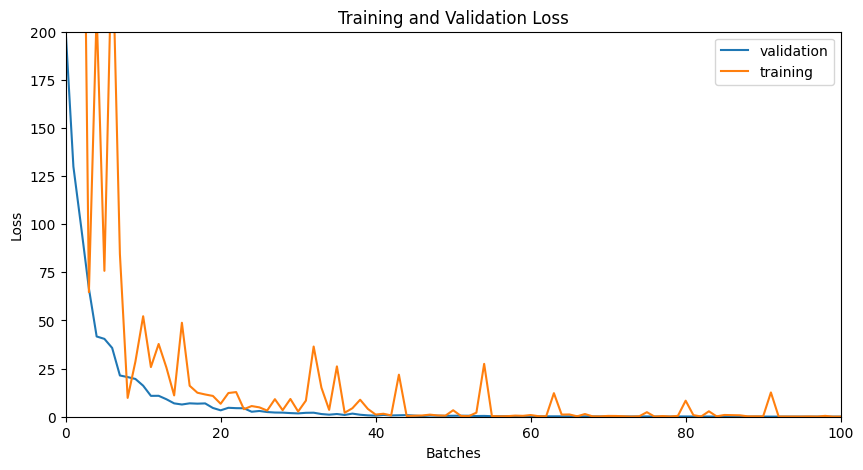

In [38]:
def plotLoss(list1, list2, label1, label2):
    plt.figure(figsize=(10,5))
    plt.ylim(0,200)
    plt.xlim(0, 100)
    plt.title("Training and Validation Loss")
    plt.plot(list1,label = label1)
    plt.plot(list2,label = label2)
    plt.xlabel("Batches")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
plotLoss(validation_loss,training_loss, "validation", "training")

In [39]:
#-----------------------Prediction-----------------------
total = 0
correct = 0
def predictionAccuracy():
    correct = 0
    for inputs, labels in test_loader:
        inputs = inputs.numpy()
        labels = labels.numpy()

        for i in range(batch_size):
            # iterate through the mini-batch and perform forward pass and backward pass
            x = inputs[i].reshape((1, D_in))                #len(inputs) = 1000, tar 1 bild=24*24=784 element
            y = np.eye(10)[labels[i]]    # 1-hot encoding
            # Forward pass
            h1 = relu(x.dot(w1))               #Layer 1
            yhat = h1.dot(w2)

            if np.where(yhat[0]==max(yhat[0])) == np.where(y==1):
                correct += 1

    print("Accuracy: ", correct/len(mnist_test))

predictionAccuracy()


Accuracy:  0.6363


# Optional task
You have now implemented a 2 layer neural network from scratch. Use this new gained knowledge to create an implementation where we can create and train any sized network. This means that we should be able to specify the structure of the network and then train it using back propagation.

In [153]:
#HANDLEDAR KODEN
h = x.dot(w1)
h_relu = np.maximum(h, 0)
yhat = h_relu.dot(w2)
loss = np.square(np.subtract(y, yhat[0])).mean()
lossDelta = 2*(yhat-y)
gradw2 = h_relu.T.dot(lossDelta)

grad_h_relu = lossDelta.dot(w2.T)
grad_h = grad_h_relu.copy()
grad_h[h < 0] = 0

gradw1 = x.T.dot(grad_h)

w1, w2 = updateWeight(gradw1, gradw2, gamma, w1, w2)

(10, 1)
(1, 10)
[[46]]
